# Random Forests Model

In [284]:
from pyquery import PyQuery as pq
import urllib2
import requests
import pandas as pd
import re
import time
import numpy as np
import json
import matplotlib.pyplot as plt
from time import sleep
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 400)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

from sklearn.metrics import roc_curve, auc
from scipy import interp

### Load dataset and make variables categorical

In [285]:
ls_2014 = "http://myneta.info/ls2014/index.php?action=show_winners&sort=default"
ls_2009 = "http://myneta.info/ls2009/index.php?action=show_winners&sort=default"
ls_2004 = "http://myneta.info/loksabha2004/index.php?action=show_winners&sort=default"
base_2014 = "http://myneta.info/ls2014/"
base_2009 = "http://myneta.info/ls2009/"
base_2004 = "http://myneta.info/loksabha2004/"

url_list={'2004':ls_2004,'2009':ls_2009,'2014':ls_2014}
base_urls = {'2004':base_2004,'2009':base_2009,'2014':base_2014}

In [286]:
candidates = pd.read_csv('../candidates.csv')   
test_size = 0.2
train_size = 0.8

candidates.Party = candidates['Party'].astype('category')
candidates.Constituency = candidates['Constituency'].astype('category')
candidates.State = candidates['State'].astype('category')
candidates.Education = candidates['Education'].astype('category')
candidates.Assets_Rs = candidates.Assets_Rs.convert_objects(convert_numeric=True)
## Some null values in Assets that needed to be cleaned up
candidates.loc[candidates.Assets_Rs.isnull(),'Assets_Rs'] = 0

candidates.Constituency = candidates.Constituency.cat.rename_categories(range(0,len(candidates.Constituency.unique())))
candidates.Party = candidates.Party.cat.rename_categories(range(0,len(candidates.Party.unique())))
candidates.State = candidates.State.cat.rename_categories(range(0,len(candidates.State.unique())))
candidates.Education = candidates.Education.cat.rename_categories(range(0,len(candidates.Education.unique())))




Merging 'Type of Crime'

In [287]:
crim_data = pd.read_csv('../criminal_record.csv')

gby_type = crim_data.groupby(['url','type']).count()
gby_type = gby_type.reset_index()
gby_type_piv = gby_type.pivot(index='url',columns='type',values='IPC_sections')
candidates['full_link'] = candidates.Year.apply(lambda x: base_urls[str(x)]) + candidates.Link

candidates = candidates.merge(gby_type_piv, how='left', left_on='full_link', right_index=True)
candidates.loc[candidates.Cogniz.isnull(),'Cogniz'] = 0
candidates.loc[candidates.Framed.isnull(),'Framed'] = 0
candidates.loc[candidates.Convict.isnull(),'Convict'] = 0

Merging 'Code of Crime'

In [288]:
def concat_IPC(IPC):
    list = []
    for x in IPC:
        #print x.strip('[').strip(']').split(', ')
        list = list + x.strip('[').strip(']').split(', ')
    return list

IPCs = crim_data[['url','IPC_sections']].groupby('url').agg(concat_IPC)
IPCs.head()

IPC_sections
url                                                                                                  
http://myneta.info/loksabha2004/candidate.php?c...  [307, 326, 324, 147, 148, 149, 307, 143, 147, ...
http://myneta.info/loksabha2004/candidate.php?c...                                   [419, 420, 120B]
http://myneta.info/loksabha2004/candidate.php?c...                          [143, 144, 145, 147, 148]
http://myneta.info/loksabha2004/candidate.php?c...  [143, 147, 148, 353, 336, 427, 435, r/w Sec 14...
http://myneta.info/loksabha2004/candidate.php?c...  [143, 147, 148, 341, 323, 324, 325, 326, 356, ...

In [289]:
# Collect all the lists
y=[]
for x in crim_data.IPC_sections:
    x = x.strip('[').strip(']').split(', ')
    type(y)
    y = y + x

# Get a set of unique codes
z=[]
for code in y:
    if len(code) > 0:
        z.append(code)
unique_codes = list(set(z))

for col in unique_codes:
    IPCs[col] = IPCs.IPC_sections.apply(lambda x: int(col in x))

candidates = candidates.merge(IPCs,how='left',left_on='full_link',right_index=True)

In [290]:
for cols in candidates.columns:
    candidates.loc[candidates[cols].isnull(),cols] = 0
candidates.head()

Unnamed: 0  Age  Assets_Rs Constituency  Criminal_Cases Education  Liabilities_Rs                            Link                   Name Party State  Winner  Year                                          full_link  Cogniz  Convict  Framed                                   IPC_sections  199  175/90  120/B  294(B)505(2)  22(1)(2)  307 OF I.P.C. & 3 & 5 OF E.S. ACT  451/34  292(A)  506/149  158A  28877/06  308/34  34.  161  344  291A  346  347  340  341  342  343  323/34  348  349  147/332/353/427  323.324.504  12(B)  34B  120B/34  228A  149.  710  120(A)  174(1)  93/2001  171(H)  16  298  299  296  297  294  295  292  293  290  291  124A  506&34  506(2)  153B  153A  115/96  194  197  196  216A  107 Cr PC  193  192  270  271  272  273  u/s380  277  278  279  566(i)  153b  153a  147/149/332/119/504  506/2  506/1  133R  380(N.P)  120BR/Wsec34  526  527  135 of Bombay Police Act  522  505B(1)  338.  449  448  &7  443  442  441  440  447  445  108  109  306  447 448  100  324/34  106  \
0           0   64    5658980           28               1         5          175115  candidate.php?candidate_id=585        Bishnu Pada Ray   132     0       1  2014  http://myneta.info/ls2014/candidate.php?candid...       0        0       1                      [147, 149, 186, 447, 511]    0       0      0             0         0                                  0       0       0        0     0         0       0    0    0    0     0    0    0    0    0    0    0       0    0    0                0            0      0    0        0     0     0    0       0       0        0       0   0    0    0    0    0    0    0    0    0    0    0     0       0       0     0     0       0    0    0    0     0          0    0    0    0    0    0    0       0    0    0    0       0     0     0                    0      0      0     0         0             0    0    0                         0    0        0     0    0    0   0    0    0    0    0    1    0    0    0    0        0    0       0    0   
1           1   41     859410           28               0         1          350000  candidate.php?candidate_id=901              A Pandian    27     0       0  2014  http://myneta.info/ls2014/candidate.php?candid...       0        0       0                                              0    0       0      0             0         0                                  0       0       0        0     0         0       0    0    0    0     0    0    0    0    0    0    0       0    0    0                0            0      0    0        0     0     0    0       0       0        0       0   0    0    0    0    0    0    0    0    0    0    0     0       0       0     0     0       0    0    0    0     0          0    0    0    0    0    0    0       0    0    0    0       0     0     0                    0      0      0     0         0             0    0    0                         0    0        0     0    0    0   0    0    0    0    0    0    0    0    0    0        0    0       0    0   
2           2   48    5471073           28               1         5            6000  candidate.php?candidate_id=584           Anita Mondal    32     0       0  2014  http://myneta.info/ls2014/candidate.php?candid...       1        0       0  [147, 148, 149, 353, 337, 333, 337, 379, 427]    0       0      0             0         0                                  0       0       0        0     0         0       0    0    0    0     0    0    0    0    0    0    0       0    0    0                0            0      0    0        0     0     0    0       0       0        0       0   0    0    0    0    0    0    0    0    0    0    0     0       0       0     0     0       0    0    0    0     0          0    0    0    0    0    0    0       0    0    0    0       0     0     0                    0      0      0     0         0             0    0    0                         0    0        0     0    0    0   0    0    0    0    0    0    0    0    0    0        0    0       0    0   
3          

## 1. With a very simple dataset

###Create test and train set

In [291]:
test_index=np.random.choice(range(candidates.count()[0]), size=0.2*candidates.count()[0], replace=False)
test_mask = candidates.index.isin(list(test_index))

test_df = candidates[test_mask]
train_df = candidates[~test_mask]

cols = list(train_df.columns)
cols.remove('Winner')
cols.remove('Unnamed: 0')
cols.remove('IPC_sections')
cols.remove('full_link')    
cols.remove('Name')
cols.remove('Link')

###A poor effort at balancing - creating weights

In [292]:
weight = [0,0]
number_of_wins = train_df.Winner[train_df.Winner == 1].count()
weight[1] = float(number_of_wins)/train_df.Winner.count()
weight[0] = 1.0-weight[1]

print weight

sample_weights = np.array(train_df.Winner.apply(lambda x: weight[x]))
#candidates.isnull()

[0.9186699764828847, 0.08133002351711523]


###Running a random forest classfier

In [293]:
train_other = train_df[['Age', 'Constituency', 'Criminal_Cases', 'Assets_Rs', 'Year',
                                  'Education', 'Liabilities_Rs', 'Party', 'State']]
test_other = test_df[['Age', 'Constituency', 'Criminal_Cases', 'Assets_Rs','Year',
                                  'Education', 'Liabilities_Rs', 'Party', 'State']]

rf = RandomForestClassifier(n_estimators=100)
rf.fit(train_other, train_df.Winner,sample_weight=sample_weights )
out = rf.predict(test_other)
all_zeroes = [0]*len(out)

###How did we do?

In [294]:
def confusion_matrix(y_hat, y):
    conf = [[0,0],[0,0]]
    for i,x in enumerate(y_hat):
        if x == 1:
            if y[i] == 1:
                conf[1][1] += 1
            if y[i] == 0:
                conf[0][1] += 1
        if x == 0:
            if y[i] == 1:
                conf[1][0] += 1
            if y[i] == 0:
                conf[0][0] += 1      
    return conf

In [295]:
print "If you guessed all as losing: %s" % rf.score(test_other, all_zeroes)
print "Current model: %s" % rf.score(test_other, test_df.Winner)

print "Confusion matrix [0,1],[0,1]: %s" % confusion_matrix(out, list(test_df.Winner))

If you guessed all as losing: 0.945635128071
Current model: 0.932566649242
Confusion matrix [0,1],[0,1]: [[3428, 68], [190, 140]]


#### ROC curves 

In [296]:
def make_roc(clf, testset, y, save=False, ax=False):
    probas_ = clf.predict_proba(testset)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y, probas_[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10,8))
    if not(ax):
        ax = plt.axes()
        
    ax.plot(fpr, tpr, lw=2, label='RF (area = %0.2f)' % (roc_auc))
    ax.plot([0,1],[0,1],ls='--')
    ax.legend(loc=0)

    if save :
        plt.savefig('roc_rf1.png', format='png')
    
    return ax

##2. Now with type of Crime thrown in

In [297]:
train_other1 = train_df[['Age', 'Constituency', 'Criminal_Cases', 'Assets_Rs','Year',
                                  'Education', 'Liabilities_Rs', 'Party', 'State','Cogniz','Convict','Framed']]
test_other1 = test_df[['Age', 'Constituency', 'Criminal_Cases', 'Assets_Rs','Year',
                                  'Education', 'Liabilities_Rs', 'Party', 'State','Cogniz','Convict','Framed']]

## Run the model
rf2 = RandomForestClassifier(n_estimators=100)
rf2.fit(train_other1, train_df.Winner,sample_weight=sample_weights )
out_crim = rf2.predict(test_other1)

## confusion matrix
conf = confusion_matrix(out_crim, list(test_df.Winner))
print "If you guessed all as losing: %s" % rf2.score(test_other1, all_zeroes)
print "Current model: %s" % rf2.score(test_other1, test_df.Winner)

print "Confusion matrix [0,1],[0,1]: %s" % conf

If you guessed all as losing: 0.956874019864
Current model: 0.928646105593
Confusion matrix [0,1],[0,1]: [[3442, 54], [219, 111]]


##3. Now with the IPC codes thrown in##

In [298]:
train_other2 = train_df[cols]
test_other2 = test_df[cols]

## Run the model
rf3 = RandomForestClassifier(n_estimators=100)
rf3.fit(train_other2, train_df.Winner,sample_weight=sample_weights )
out_crim = rf3.predict(test_other2)

## confusion matrix
conf = confusion_matrix(out_crim, list(test_df.Winner))
print "If you guessed all as losing: %s" % rf3.score(test_other2, all_zeroes)
print "Current model: %s" % rf3.score(test_other2, test_df.Winner)

print "Confusion matrix [0,1],[0,1]: %s" % conf



If you guessed all as losing: 0.974647151072
Current model: 0.92812336644
Confusion matrix [0,1],[0,1]: [[3475, 21], [254, 76]]


##4. With Liabilities and Assets thrown in

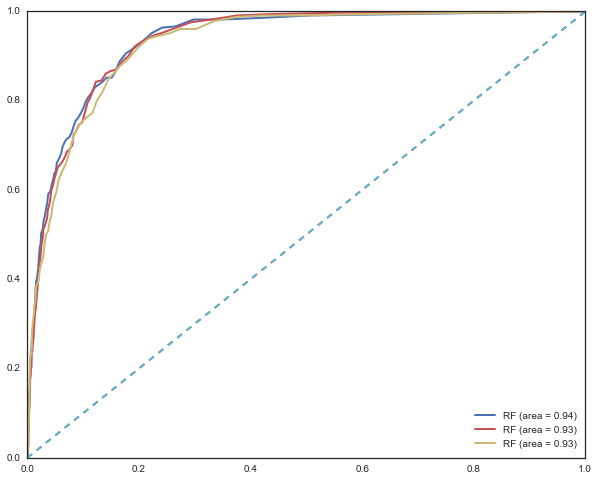

In [299]:
ax = make_roc(rf, test_other, list(test_df.Winner))
make_roc(rf2, test_other1, list(test_df.Winner), ax=ax)
make_roc(rf3, test_other2, list(test_df.Winner), ax=ax)